In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append("../")
DATA_PATH = '../data/'

## Data

In [2]:
k = 1
sampled_data = pd.read_pickle(DATA_PATH + 'train_data.pkl').sample(frac=k, random_state=137)
# sample size

In [3]:
# scaling data
%load_ext autoreload
%autoreload 2

# split on train and test
from sklearn.model_selection import train_test_split
from data_pipeline import dropFalseMCParticles

unused_features = [
    'index', 'seed_nbIT', 'seed_nLayers', 'seed_mva_value',
    'is_downstream_reconstructible_not_electron', 'is_true_seed',
    'has_MCParticle_not_electron'
]
data = sampled_data.drop(unused_features, axis=1)
data = dropFalseMCParticles().fit_transform(data)
data = data.astype(np.float32)

data.info()

train_set, test_set = train_test_split(data, test_size=0.3, random_state=42)
label_names = [
    'is_downstream_reconstructible'
]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1754766 entries, 1042314 to 3481
Data columns (total 9 columns):
is_downstream_reconstructible    float32
seed_chi2PerDoF                  float32
seed_p                           float32
seed_pt                          float32
seed_nLHCbIDs                    float32
seed_x                           float32
seed_y                           float32
seed_tx                          float32
seed_ty                          float32
dtypes: float32(9)
memory usage: 73.6 MB


### limited features tupled model

In [4]:
x_train = train_set.drop(label_names, axis=1)
y_train = train_set[label_names].copy().astype(np.int32)

x_test = test_set.drop(label_names, axis=1)
y_test = test_set[label_names].copy().astype(np.int32)



from data_pipeline import data_pipeline_basic as data_pipeline
pipeline = data_pipeline()
x_train = pipeline.fit_transform(x_train)
x_test = pipeline.transform(x_test)


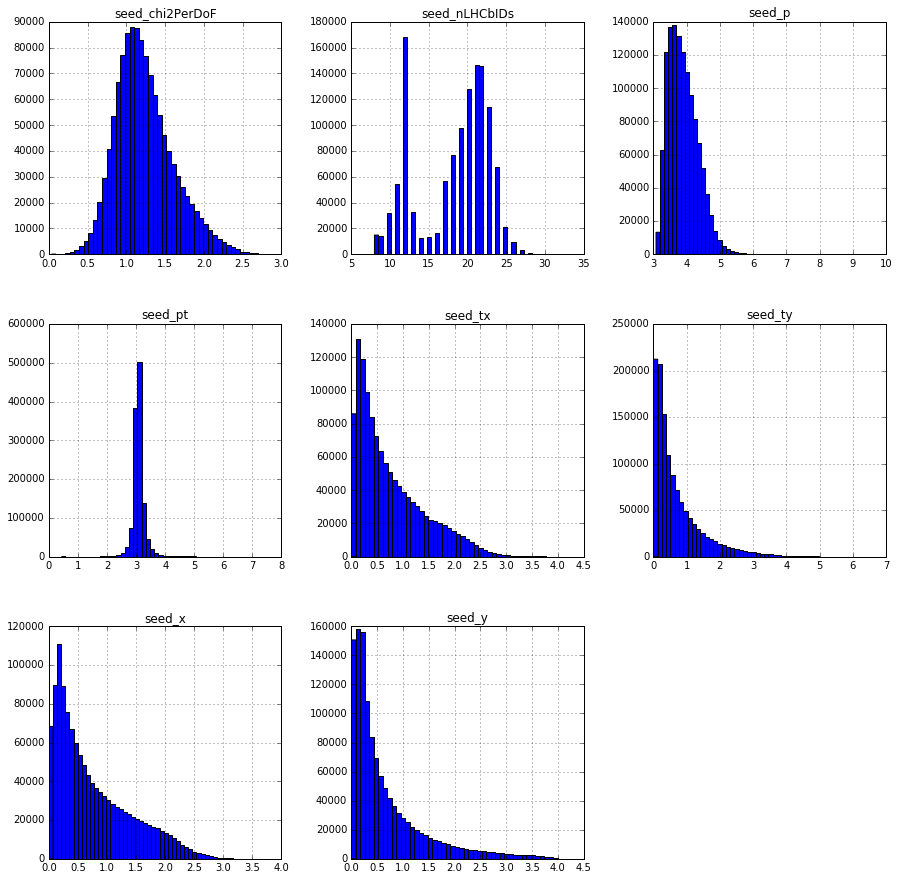

In [5]:
_ = x_train.hist(bins=50, figsize=(15,15))

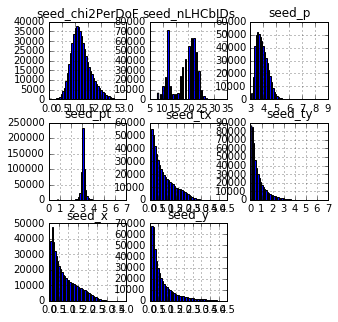

In [6]:
_ = x_test.hist(bins=50, figsize=(5,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9401959160>]], dtype=object)

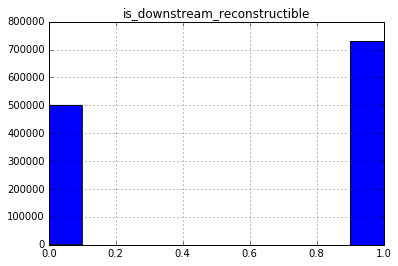

In [7]:
y_train.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f94018ea908>]], dtype=object)

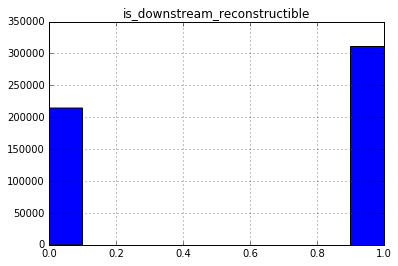

In [8]:
y_test.hist()

In [9]:
from sklearn.utils import class_weight

class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train['is_downstream_reconstructible']), y_train['is_downstream_reconstructible'])

In [10]:
from keras.callbacks import TensorBoard
from models import KerasDNN
from models import LookupClassifier
import time

date_created = time.ctime()

DNNclf = KerasDNN(
    (x_train.shape[1],),
    (2,),
    neurons=100,
    layers=3,
    dropout=0.05,
    loss_metric='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    last_layer_act='softmax'
)



lc = LookupClassifier(base_estimator=DNNclf, n_bins=8,)
lc.fit(
    x_train, y_train['is_downstream_reconstructible'],
    epochs=8,
    class_weight=class_weight
)

Using TensorFlow backend.


Epoch 1/8
1228336/1228336 [==============================] - 129s - loss: 0.4209 - acc: 0.8199   
Epoch 2/8
1228336/1228336 [==============================] - 127s - loss: 0.4049 - acc: 0.8287   
Epoch 3/8
1228336/1228336 [==============================] - 131s - loss: 0.4013 - acc: 0.8309   
Epoch 4/8
1228336/1228336 [==============================] - 129s - loss: 0.3988 - acc: 0.8321   
Epoch 5/8
1228336/1228336 [==============================] - 125s - loss: 0.3976 - acc: 0.8329   
Epoch 6/8
1228336/1228336 [==============================] - 125s - loss: 0.3963 - acc: 0.8337   
Epoch 7/8
1228336/1228336 [==============================] - 125s - loss: 0.3955 - acc: 0.8341   
Epoch 8/8
1228336/1228336 [==============================] - 125s - loss: 0.3948 - acc: 0.8341   


LookupClassifier(base_estimator=KerasDNN(activation='relu', batch_norm=True, dropout=0.05, input_shape=(8,),
     last_layer_act='softmax', layers=3,
     loss_metric='sparse_categorical_crossentropy', metrics=['accuracy'],
     neurons=100, optimizer='adam', output_shape=(2,)),
         keep_trained_estimator=True, max_cells=500000000, n_bins=8)

In [11]:
from sklearn.metrics import accuracy_score

In [12]:
%time accuracy_score(y_test.values, lc.predict(x_test))

CPU times: user 200 ms, sys: 4 ms, total: 204 ms
Wall time: 201 ms


0.84136352411526694

In [13]:
from sklearn.metrics import roc_auc_score

In [14]:
roc_auc_score(y_test.values, lc.predict_proba(x_test)[:,1] )

0.89558177855176535

In [15]:
import itertools
lookup_table = list(lc._lookup_table[:,0])

n_features = x_train.shape[1]
all_bins_indices = list(itertools.product(range(lc.n_bins), repeat=n_features)) 
all_bins_indices_df = pd.DataFrame(all_bins_indices,columns=x_train.columns.values )
all_bins_indices_df.head()


lookup_indices = lc.convert_bins_to_lookup_index(all_bins_indices_df)
predictions = np.array(lc._lookup_table[lookup_indices] [:,1])

all_bins_indices_df['pred'] = predictions
all_bins_indices_df.head()

!mkdir -p  ../saved_models/lookup_tables/


all_bins_indices_df.to_csv('../saved_models/lookup_tables/NN_tuple_{}.csv'.format(date_created), index=False)
with open('../saved_models/lookup_tables/NN_tuple_{}_params.txt'.format(time.ctime()), 'w') as params_file:
    print(lc.get_params(), file=params_file)
    print(lc.base_estimator.get_params(), file=params_file)

In [16]:
lc.bin_edges

OrderedDict([('seed_chi2PerDoF',
              array([ 0.83062252,  0.96644998,  1.07437367,  1.18069363,  1.29992735,
                      1.45262793,  1.69217433])),
             ('seed_p',
              array([ 3.40419179,  3.54774621,  3.6885446 ,  3.83795882,  4.00216395,
                      4.19318874,  4.4455246 ])),
             ('seed_pt',
              array([ 2.93287723,  3.00056036,  3.03630805,  3.06373024,  3.09747968,
                      3.14478531,  3.23500653])),
             ('seed_nLHCbIDs',
              array([ 12.,  12.,  18.,  19.,  21.,  22.,  23.])),
             ('seed_x',
              array([ 0.13584864,  0.22773442,  0.3582022 ,  0.53572184,  0.78708478,
                      1.13540374,  1.62112611])),
             ('seed_y',
              array([ 0.07860986,  0.15307448,  0.22609695,  0.3432065 ,  0.53055965,
                      0.83622647,  1.43651448])),
             ('seed_tx',
              array([ 0.13049002,  0.23009712,  0.36059922,  0.53683

In [17]:
def generate_InitBinEdgeMap_function():
    function_body = """
void PatBBDTSeedClassifier::initBinEdgeMaps()
{
    m_binsEdgeMap ={
    """
    for feature, bins_edges in lc.bin_edges.items():
        function_body += "\t {\"" + str(feature) +"\", {"
        for bin_edge in bins_edges:
            function_body += str(bin_edge)+ ","
        function_body +=  "}},\n"
    
    function_body += """\n };
}
    """
    return function_body
print(generate_InitBinEdgeMap_function())



void PatBBDTSeedClassifier::initBinEdgeMaps()
{
    m_binsEdgeMap ={
    	 {"seed_chi2PerDoF", {0.83062251768,0.966449975967,1.07437366956,1.1806936264,1.29992735386,1.45262792889,1.6921743315,}},
	 {"seed_p", {3.40419179023,3.54774620985,3.6885446049,3.83795881814,4.00216394749,4.19318873788,4.44552460337,}},
	 {"seed_pt", {2.93287723089,3.00056036336,3.03630805016,3.06373023987,3.09747967679,3.14478530602,3.23500652822,}},
	 {"seed_nLHCbIDs", {12.0,12.0,18.0,19.0,21.0,22.0,23.0,}},
	 {"seed_x", {0.13584864002,0.227734415294,0.358202199672,0.535721838474,0.78708477677,1.13540373566,1.62112611253,}},
	 {"seed_y", {0.0786098579155,0.153074478715,0.226096953958,0.343206497893,0.530559645248,0.83622646678,1.43651447563,}},
	 {"seed_tx", {0.130490017939,0.230097115693,0.360599216109,0.536835267813,0.780595404923,1.11747034859,1.62756533932,}},
	 {"seed_ty", {0.0838901448342,0.167362714627,0.256956820805,0.393944647835,0.599766724659,0.912113262057,1.47878086304,}},

 };
}
    


In [18]:
lc.base_estimator.get_params()

{'activation': 'relu',
 'batch_norm': True,
 'dropout': 0.05,
 'input_shape': (8,),
 'last_layer_act': 'softmax',
 'layers': 3,
 'loss_metric': 'sparse_categorical_crossentropy',
 'metrics': ['accuracy'],
 'neurons': 100,
 'optimizer': 'adam',
 'output_shape': (2,)}

In [19]:
DNNclf.get_params()

{'activation': 'relu',
 'batch_norm': True,
 'dropout': 0.05,
 'input_shape': (8,),
 'last_layer_act': 'softmax',
 'layers': 3,
 'loss_metric': 'sparse_categorical_crossentropy',
 'metrics': ['accuracy'],
 'neurons': 100,
 'optimizer': 'adam',
 'output_shape': (2,)}

In [20]:
pipeline.named_steps

{'chi2sqrt': chi2sqrt(),
 'plog': plog(),
 'ptlog': ptlog(),
 'tx_abs': txScale_abs(),
 'ty_abs': tyScale_abs(),
 'x_abs': xScale_abs(),
 'y_abs': yScale_abs()}

In [21]:
for name, step in pipeline.named_steps.items():
    print(step)
    try:
        print(step.scaler.scale_)
        print('std: ', step.scaler.scale_)
        print('mean: ', step.scaler.mean_)
    except Exception as e:
            pass

chi2sqrt()
ptlog()
xScale_abs()
[ 718.45885408]
std:  [ 718.45885408]
mean:  [-3.58761813]
plog()
txScale_abs()
[ 0.29576847]
std:  [ 0.29576847]
mean:  [-0.00422249]
yScale_abs()
[ 504.799883]
std:  [ 504.799883]
mean:  [ 1.0987292]
tyScale_abs()
[ 0.06486862]
std:  [ 0.06486862]
mean:  [ 0.00013073]


In [22]:
import gc
gc.collect()

452